# Weibull Accelerated Failure Time Models

In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels
import patsy
import theano.tensor as tt

plt.style.use('seaborn-darkgrid')
print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.4.1


The [previous example notebook on Bayesian parametric survival analysis](https://docs.pymc.io/notebooks/bayes_param_survival.html) introduced two different accelerated failure time (AFT) models: Weibull and log-linear. In this notebook, we will explore three different versions/parameterizations of the Weibull AFT model.

The data set we'll use is the `flchain` R data set, which comes from a medical study investigating the effect of serum free light chain (FLC) on lifespan. Read the full documentation of the data by running:

`print(statsmodels.datasets.get_rdataset(package='survival', dataname='flchain').__doc__)`.

Here, we are interested in seeing what effect, if any, the `age` and `sex` covariates have on the survival times of subjects.

In [2]:
# Fetch and clean data
data = (statsmodels.datasets
                   .get_rdataset(package='survival', dataname='flchain')
                   .data
                   .sample(500)  # Limit ourselves to 500 observations
                   .reset_index(drop=True))

In [3]:
data.head()

,age,sex,sample.yr,kappa,lambda,flc.grp,creatinine,mgus,futime,death,chapter
0,50,M,1998,0.888,0.396,1,1.1,1,4173,0,NaN
1,55,M,1997,0.691,1.180,2,1.1,0,4533,0,NaN
2,72,F,1996,1.680,1.540,7,0.9,0,414,1,Neoplasms
3,87,M,1999,2.840,2.140,10,1.0,0,520,1,Nervous
4,83,F,1996,1.470,1.840,7,0.9,0,1705,1,Circulatory


In [4]:
# Get matrices of covariates from dataframe using patsy
_, X_df = patsy.dmatrices("death ~ age + sex", data, return_type='dataframe')
X_df = X_df.iloc[:, X_df.columns != 'Intercept']

# `X` contains covariates, `y` contains survival times, and `censored`
# contains whether or not the survival time has been censored
X = X_df.values
y = data.futime.values
censored = ~data['death'].values.astype(bool)

## Model 1

[Weibull Survival Regression](https://discourse.pymc.io/t/weibull-survival-regression-aft/1107/3)

In [25]:
def weibull_lccdf(value, alpha, beta):
    ''' Log complementary cdf of Weibull distribution. '''
    return - (value / beta)**alpha


with pm.Model() as model_1:
    alpha_sd = 10.0

    mu = pm.Normal('mu', mu=0, sd=100)
    alpha_raw = pm.Normal('a0', mu=0, sd=0.1)
    alpha = pm.Deterministic('alpha', tt.exp(alpha_sd * alpha_raw))
    beta = pm.Deterministic('beta', tt.exp(mu / alpha))
    
    y_obs = pm.Weibull('y_obs', alpha=alpha, beta=beta, observed=y[~censored])
    y_cens = pm.Potential('y_cens', weibull_lccdf(y[censored], alpha, beta))

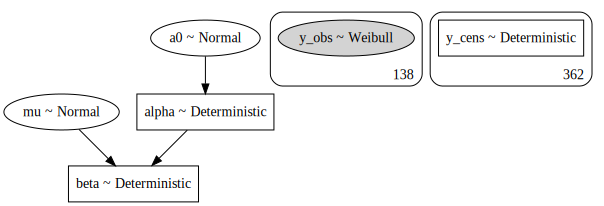

In [26]:
pm.model_to_graphviz(model_1)

In [59]:
with model_1:
    # Increase tune and change init to avoid divergences
    trace_1 = pm.sample(draws=1000, tune=1000,
                        nuts_kwargs={'target_accept': 0.9},
                        init='adapt_diag')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a0, mu]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:05<00:00, 778.41draws/s]
The number of effective samples is smaller than 25% for some parameters.


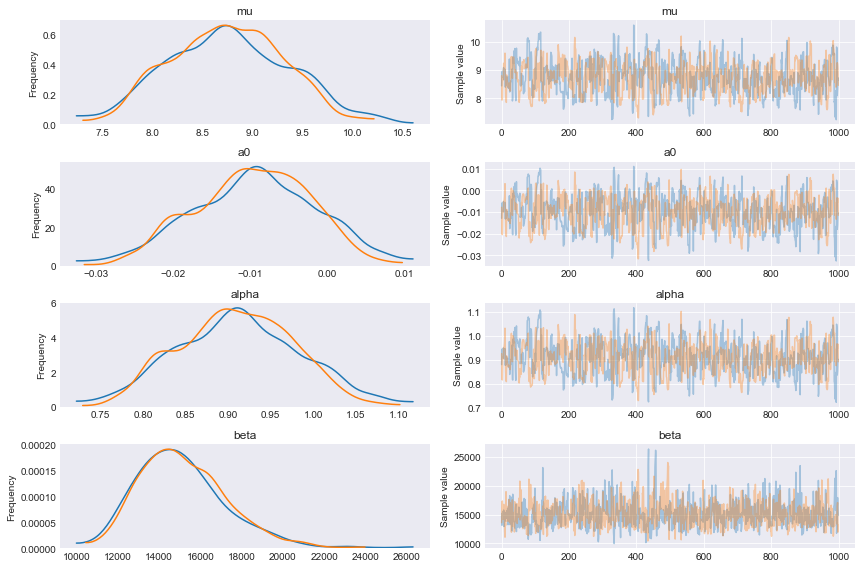

In [60]:
pm.traceplot(trace_1);

In [61]:
pm.summary(trace_1)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu,8.744989,0.586468,0.026957,7.644604,9.827153,434.444652,1.000030
a0,-0.009686,0.007725,0.000355,-0.025653,0.003720,438.444507,1.000008
alpha,0.910390,0.070062,0.003222,0.770977,1.034469,434.426233,1.000247
beta,15116.076700,2166.298721,77.640994,11249.126102,19276.560218,748.141079,1.000202


## Model 2

https://github.com/stan-dev/example-models/blob/master/bugs_examples/vol1/kidney/kidney.stan

In [42]:
with pm.Model() as model_2:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    r = pm.Gamma('r', alpha=1, beta=0.001, testval=0.25)
    beta = pm.Deterministic('beta', tt.exp(-alpha / r))

    y_obs = pm.Weibull('y_obs', alpha=r, beta=beta, observed=y[~censored])
    y_cens = pm.Bernoulli('y_cens', tt.exp(-tt.pow(y[censored] / beta, r)), observed=np.ones(np.sum(censored)))

#     y0 = pm.Potential(
#         'y0', weibull_lccdf(time[event == 0], r, beta))

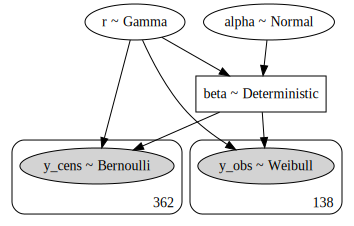

In [44]:
pm.model_to_graphviz(model_2)

In [51]:
with model_2:
    # Increase tune and target_accept to avoid divergences
    trace_2 = pm.sample(draws=1000, tune=1000,
                        nuts_kwargs={'target_accept': 0.9})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [r, alpha]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:05<00:00, 698.11draws/s]
The number of effective samples is smaller than 25% for some parameters.


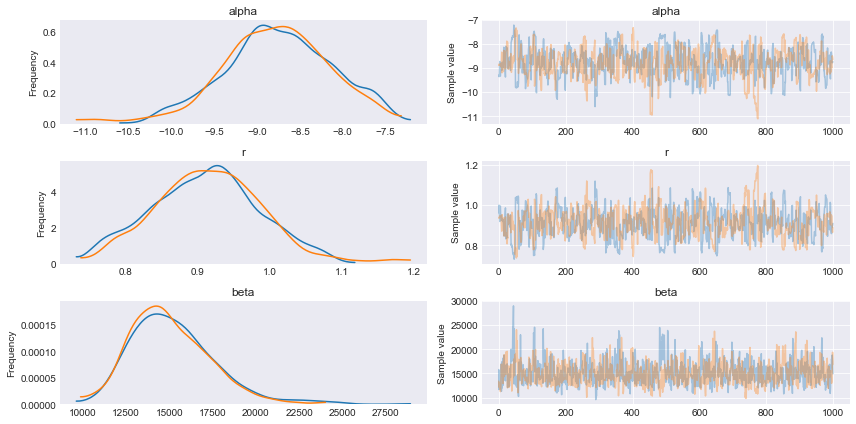

In [52]:
pm.traceplot(trace_2);

In [53]:
pm.summary(trace_2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,-8.772751,0.622550,0.029959,-9.942448,-7.572132,386.911734,1.001713
r,0.913614,0.074835,0.003587,0.756951,1.041459,390.984119,1.002122
beta,15108.719658,2355.591253,89.773085,10892.856930,19627.202143,619.250816,1.002945


## Model 3

Original parameterization from [here](http://austinrochford.com/posts/2017-10-02-bayes-param-survival.html).

In [65]:
logtime = np.log(y)

def gumbel_sf(y, mu, sigma):
    ''' Gumbel survival function. '''
    return 1.0 - tt.exp(-tt.exp(-(y - mu) / sigma))


with pm.Model() as model_3:
    s = pm.HalfNormal('s', tau=5.0)
    gamma = pm.Normal('gamma', mu=0, sd=5)

    y_obs = pm.Gumbel('y_obs', mu=gamma, beta=s, observed=logtime[~censored])
    y_cens = pm.Bernoulli('y_cens', p=gumbel_sf(logtime[censored], mu=gamma, sigma=s),
                          observed=np.ones(np.sum(censored)))

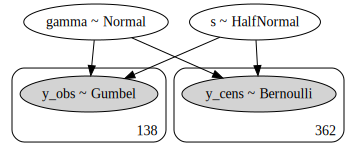

In [66]:
pm.model_to_graphviz(model_3)

In [68]:
with model_3:
    trace_3 = pm.sample(draws=1000, tune=1000,
                        init='adapt_diag')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [gamma, s]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:02<00:00, 1990.44draws/s]


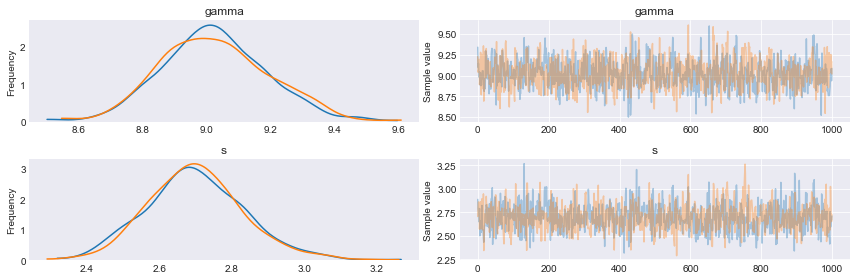

In [70]:
pm.traceplot(trace_3);

In [72]:
pm.summary(trace_3)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
gamma,9.022599,0.166404,0.004447,8.717356,9.348773,1060.260205,0.999543
s,2.699170,0.134041,0.003989,2.431658,2.953627,1050.777846,0.999503


## Authors

- Originally researched by [Junpeng Lao](https://junpenglao.xyz/) on Apr 21, 2018. See original code [here](https://github.com/junpenglao/Planet_Sakaar_Data_Science/blob/65447fdb431c78b15fbeaef51b8c059f46c9e8d6/PyMC3QnA/discourse_1107.ipynb).
- Authored and ported to Jupyter notebook by [George Ho](https://eigenfoo.xyz/) on Jul 15, 2018.